# Migration Data Download

Get occurrence data from the Global Biodiversity Information Facility
(GBIF)

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [36]:
import json
import requests

import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import shape

In [2]:
%store -r

In [7]:
print(gbif_gdf)

           decimalLatitude decimalLongitude  month
gbifID                                            
4051023326        44.92053          5.45247    4.0
4050744005        44.86102          5.42571    2.0
4051689283        44.93771          5.45883    3.0
4051420749        44.84309          5.50722   12.0
4051829031        45.05594          5.89898   12.0
...                    ...              ...    ...
4085703411         43.5281          5.25701    6.0
4085650640        44.12204          4.78063    6.0
4085446521        44.01287          5.71291    4.0
4085611055        43.73492          6.01019    4.0
4598417443        59.48555         24.68919    5.0

[164804 rows x 3 columns]


In [ ]:
#had issues with values that weren't number, so had to drop those values

#  Make clean numeric copies of lat/lon
gbif_gdf["decimalLatitude_num"] = pd.to_numeric(
    gbif_gdf["decimalLatitude"], errors="coerce"
)
gbif_gdf["decimalLongitude_num"] = pd.to_numeric(
    gbif_gdf["decimalLongitude"], errors="coerce"
)

#  Drop rows where either lat or lon is missing (bad / non-numeric)
gbif_gdf = gbif_gdf.dropna(subset=["decimalLatitude_num", "decimalLongitude_num"]).copy()


In [16]:
# 3. Build a proper GeoDataFrame from the cleaned data
gbif_gdf = gpd.GeoDataFrame(
    gbif_gdf,
    geometry=gpd.points_from_xy(
        gbif_gdf["decimalLongitude_num"],
        gbif_gdf["decimalLatitude_num"]
    ),
    crs="EPSG:4326"
)


print(gbif_gdf)

           decimalLatitude decimalLongitude  month  decimalLatitude_num  \
gbifID                                                                    
4051023326        44.92053          5.45247    4.0             44.92053   
4050744005        44.86102          5.42571    2.0             44.86102   
4051689283        44.93771          5.45883    3.0             44.93771   
4051420749        44.84309          5.50722   12.0             44.84309   
4051829031        45.05594          5.89898   12.0             45.05594   
...                    ...              ...    ...                  ...   
4085703411         43.5281          5.25701    6.0             43.52810   
4085650640        44.12204          4.78063    6.0             44.12204   
4085446521        44.01287          5.71291    4.0             44.01287   
4085611055        43.73492          6.01019    4.0             43.73492   
4598417443        59.48555         24.68919    5.0             59.48555   

            decimalLongi

/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_72623/2570304573.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gbif_union = gbif_gdf.geometry.unary_union.envelope


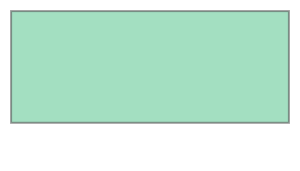

In [17]:
# Merge the GBIF observations into a single geometry
gbif_union = gbif_gdf.geometry.unary_union.envelope
gbif_union


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Run the code below, which converts your Polygon to a special type of
GeoJSON needed for compatibility with the ArcGIS Feature Service. Check
out and explore this data structure. How would you extract the
geographic coordinates?</p></div></div>

In [18]:
# Convert geometry to geoJSON
gbif_geojson = gbif_union.__geo_interface__

gbif_geojson

{'type': 'Polygon',
 'coordinates': (((-177.08021, -54.947755),
   (178.846303, -54.947755),
   (178.846303, 88.1333),
   (-177.08021, 88.1333),
   (-177.08021, -54.947755)),)}

In [19]:
# Convert geometry to geoJSON
gbif_geojson = gbif_union.__geo_interface__

gbif_geojson

{'type': 'Polygon',
 'coordinates': (((-177.08021, -54.947755),
   (178.846303, -54.947755),
   (178.846303, 88.1333),
   (-177.08021, 88.1333),
   (-177.08021, -54.947755)),)}

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What type of Python object is this geoJSON? How will you get the
geographic coordinates only?</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>feature-key</code> with the coordinate key you noted
above.</li>
<li>Replace CRS with the CRS of your GBIF download. It should be
formatted as a 4-digit number, e.g. if the CRS is EPSG:1234, you should
put <code>1234</code> into Python.</li>
</ol></div></div>

In [25]:
# Construct ArcGIS-compatible JSON
arcgis_geom = json.dumps(dict(
    rings=gbif_geojson["coordinates"],
    spatialReference={"wkid": 4326}
))

In [26]:
# Construct ArcGIS-compatible JSON
arcgis_geom = json.dumps(dict(
    rings=gbif_geojson["coordinates"],
    spatialReference={"wkid": 4326}
))

### STEP 2: Download data from the ArcGIS FeatureService


In [39]:


eco_params_attrs = {
    "f": "geojson",
    "where": "1=1",
    "outFields": "eco_code,area_km2",
    "returnGeometry": "false",
    "spatialRel": "esriSpatialRelIntersects",
    "geometryType": "esriGeometryPolygon",
    "inSR": "4326",
    "outSR": "4326",
    "geometry": arcgis_geom
}

resp_attrs = requests.get(
    eco_url,
    params=eco_params_attrs,
    headers={"Accept-Encoding": "identity"},
    timeout=60
)
resp_attrs.raise_for_status()

data_attrs = resp_attrs.json()
records = [f["properties"] for f in data_attrs["features"]]
ecoregions_df = pd.DataFrame(records)
ecoregions_df.head()


,eco_code,area_km2
0,NT0404,248398
1,NT0404,248398
2,AT1012,19515
3,OC0103,212
4,OC0115,943


In [31]:
# Prepare API request
eco_url = (
    "https://services5.arcgis.com/0AFsQflykfA9lXZn"
    "/ArcGIS/rest/services"
    "/WWF_Terrestrial_Ecoregions_Of_The_World_official_teow"
    "/FeatureServer/0/query")
eco_params = {
    "f": "geojson",
    "where": "1=1",
    "outFields": "eco_code,area_km2",
    "returnGeometry": "true",
    # Return polygons containing any GBIF observation
    "spatialRel": "esriSpatialRelIntersects",  
    "geometryType": "esriGeometryPolygon",
    # Override web Mercator server default
    "inSR": "4326",
    "outSR": "4326",
    # Must format geometry
    "geometry": arcgis_geom
}

# Submit API request
eco_resp = requests.get(
    eco_url, params=eco_params,
    headers={"Accept-Encoding": "identity"})
eco_resp.raise_for_status()

# Load binary data to DataFrame
eco_gdf = gpd.read_file(BytesIO(eco_resp.content))

# Check the download
eco_gdf.head()

ChunkedEncodingError: ('Connection broken: IncompleteRead(20721332 bytes read, 122017 more expected)', IncompleteRead(20721332 bytes read, 122017 more expected))

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Now, make a quick plot of your download to make sure that it worked
correctly.</p></div></div>

In [10]:
# Plot the ecoregion data

In [40]:
all_polys = []

for code in ecoregions_df["eco_code"].unique():
    params_single = {
        "f": "geojson",
        "where": f"eco_code='{code}'",
        "outFields": "eco_code,area_km2",
        "returnGeometry": "true",
        "geometryType": "esriGeometryPolygon",
        "inSR": "4326",
        "outSR": "4326",
    }
    r = requests.get(eco_url, params=params_single, timeout=60)
    r.raise_for_status()
    for feat in r.json()["features"]:
        all_polys.append({
            **feat["properties"],
            "geometry": shape(feat["geometry"])
        })

eco_shapes_gdf = gpd.GeoDataFrame(all_polys, crs="EPSG:4326")
eco_shapes_gdf.head()

,eco_code,area_km2,geometry
0,NT0404,248398,"POLYGON ((-73.52096 -42.60415, -73.53159 -42.6..."
1,NT0404,248398,"POLYGON ((-73.21118 -42.63243, -73.22204 -42.6..."
2,NT0404,248398,"POLYGON ((-73.57899 -42.709, -73.58126 -42.706..."
3,NT0404,248398,"POLYGON ((-73.26454 -42.617, -73.28247 -42.612..."
4,NT0404,248398,"POLYGON ((-73.00954 -42.65304, -73.0188 -42.64..."


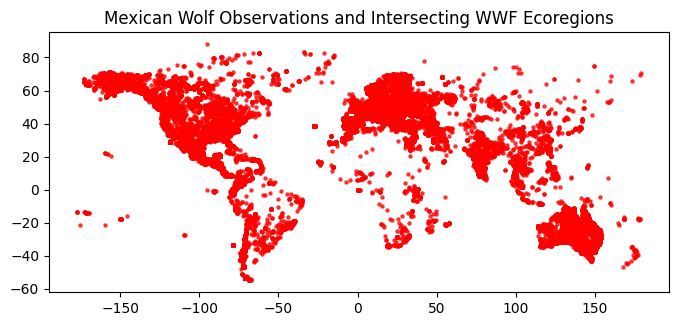

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
eco_shapes_gdf.boundary.plot(ax=ax, color="black", linewidth=1)
gbif_gdf.plot(ax=ax, markersize=5, color="red", alpha=0.7)
ax.set_title("Mexican Wolf Observations and Intersecting WWF Ecoregions")
plt.show()


### STEP 3 (Optional): Save your data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Create a new directory in your data directory for the ecoregions
data.</li>
<li>Define a path to a Shapefile where you will save the ecoregions
data.</li>
<li>Save the ecoregions to the file.</li>
</ol></div></div>

In [12]:
# Save the ecoregion data

In [13]:
# Save the ecoregion data
eco_dir = project.project_dir / 'ecoregions'
eco_dir.mkdir(exist_ok=True)
eco_path = eco_dir / 'ecoregions.shp'
eco_gdf.to_file(eco_path)